In [7]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

spark = (
    SparkSession.builder.appName("pagerank_homework")
    .config("spark.jars.packages", "io.graphframes:graphframes-spark4_2.13:0.10.0")
    .master("local[*]")
    .getOrCreate()
)

In [8]:
from pyspark.sql import Row

# Create vertices DataFrame-5 nodes
vertices = spark.createDataFrame(
    [
        Row(id="ID1"),
        Row(id="ID2"),
        Row(id="ID3"),
        Row(id="ID4"),
        Row(id="ID5"),
    ]
)

# Create edges DataFrame according to homework graph
edges = spark.createDataFrame(
    [
        ("ID1", "ID2"),
        ("ID1", "ID3"),
        ("ID2", "ID3"),
        ("ID2", "ID4"),
        ("ID2", "ID5"),
        ("ID3", "ID5"),
        ("ID4", "ID3"),
        ("ID5", "ID2"),
        ("ID5", "ID3"),
    ],
    ["src", "dst"],
)

vertices.show()
edges.show()

+---+
| id|
+---+
|ID1|
|ID2|
|ID3|
|ID4|
|ID5|
+---+

+---+---+
|src|dst|
+---+---+
|ID1|ID2|
|ID1|ID3|
|ID2|ID3|
|ID2|ID4|
|ID2|ID5|
|ID3|ID5|
|ID4|ID3|
|ID5|ID2|
|ID5|ID3|
+---+---+



In [9]:
# Build GraphFrame object from vertices and edges
g = GraphFrame(vertices, edges)

# Run PageRank:
# resetProbability = 0.2 
# tol = 0.1 
pr = g.pageRank(resetProbability=0.2, tol=0.1)

# Show PageRank scores for each node in descending order
pr.vertices.select("id", "pagerank") \
    .orderBy("pagerank", ascending=False) \
    .show(truncate=False)

26/01/18 23:52:18 WARN ShippableVertexPartitionOps: Joining two VertexPartitions with different indexes is slow.
26/01/18 23:52:19 WARN PageRank: Returned DataFrame is persistent and materialized!


+---+------------------+
|id |pagerank          |
+---+------------------+
|ID5|1.5717903729581382|
|ID3|1.5259982744360148|
|ID2|1.0676314070480593|
|ID4|0.5210690470829273|
|ID1|0.31351089847486  |
+---+------------------+



In [10]:
from pyspark.sql import functions as F

# Check number of outgoing edges for each node
g.outDegrees.orderBy("id").show()

+---+---------+
| id|outDegree|
+---+---------+
|ID1|        2|
|ID2|        3|
|ID3|        1|
|ID4|        1|
|ID5|        2|
+---+---------+



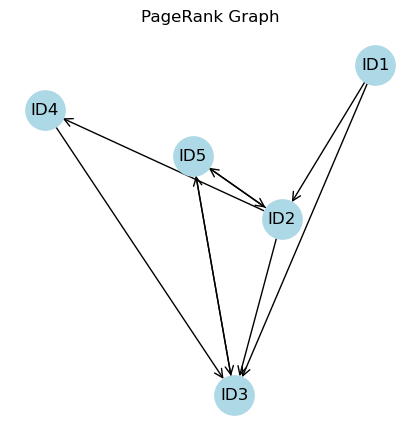

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Collect edges from Spark DataFrame into a Python list
edge_list = edges.select("src", "dst").collect()

# Build a directed graph in networkx
G = nx.DiGraph()
for row in edge_list:
    G.add_edge(row["src"], row["dst"])

# Draw the graph
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=800,
    arrows=True,
    arrowstyle="->",
    arrowsize=15,
)
plt.title("PageRank Graph")
plt.axis("off")
plt.show()